# **PRÀCTICA 1: Identificació d'idioma**

# Main program

## Setup

In [1]:
import math
import json
from typing import Callable
from functions import *
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load trigrams and unique characters from json files
def dict_string_to_trigramtuple(d: dict) -> dict:
    return {key: {tuple(k): v for k, v in value.items()} for key, value in d.items()}

def refactor_validation(d: dict) -> dict:
    return {key: ({tuple(k2): v2 for k2, v2 in value[0].items()}, value[1]) for key, value in d.items()}

trigrams = dict_string_to_trigramtuple(json.load(open('./weights/trigrams.json')))
unique_chars = json.load(open('./weights/unique_chars.json'))

# Load preprocessed data (train and test)
train = json.load(open('./preprocessed_langId/train.json'))
test = json.load(open('./preprocessed_langId/test.json'))

validation_trigrams = refactor_validation(json.load(open('./weights/validation_trigrams.json')))
validation_unique = json.load(open('./weights/validation_unique_chars.json'))


In [3]:
totals = {key: sum(trigrams[key].values()) for key in trigrams.keys()}

b_value_dict = {key: value ** 3 for key, value in unique_chars.items()} # Different b value for each language
b_value_max = max(b_value_dict.values()) # Max b value. Same for all languages
b_value_min = min(b_value_dict.values()) # Min b value. Same for all languages
b_value_mean = int(round(np.mean(list(unique_chars.values())))) ** 3 # Mean b value. Same for all languages
b_values = {key: b_value_mean for key, value in unique_chars.items()}

print('Max b value:', b_value_max, math.cbrt(b_value_max))
print('Mean b value:', b_value_mean, math.cbrt(b_value_mean))
print('Min b value:', b_value_min, math.cbrt(b_value_min))

Max b value: 373248 72.0
Mean b value: 262144 64.0
Min b value: 125000 50.0


In [4]:
# Test the Lidstone smoothing
text = '  Prueba de ejemplo  '
probs = []
languages = {"deu": "Deutsch (German)", 
             "eng": "English (English)", 
             "fra": "Français (French)", 
             "ita": "Italiano (Italian)", 
             "spa": "Español (Spanish)", 
             "nld": "Nederlands (Dutch)"}
total_trigrams = {key: sum(dicts.values()) for key, dicts in trigrams.items()}
for language in trigrams.keys():
    prob = probs_total(b_value=b_value_dict[language], text=text, model=trigrams[language], total_trigrams=total_trigrams[language], smooth=absolute_discounting, param=0.1,)
    probs.append((language, prob))
max_probs = max(probs, key = lambda x: x[1])
print(max_probs)
probs = sorted(probs, key = lambda x: x[1], reverse=True)

# Normalize the probabilities and print the results
exp = [math.exp(p[1] - max_probs[1]) for p in probs]
normalize = [(e / sum (exp))*100 for e in exp]
lang = [languages[p[0]] for p in probs]
for e in range(len(lang)):
    print(f"{lang[e]}: {normalize[e]}")

('spa', -195.96177974266246)
Español (Spanish): 99.99999999999997
English (English): 2.246530279228865e-14
Nederlands (Dutch): 5.637819616217063e-16
Deutsch (German): 8.132271707730243e-17
Français (French): 2.805800850294424e-17
Italiano (Italian): 1.7927120911225645e-22


## Validation

In [5]:
unique_trigrams = set()
for k in trigrams.keys():
    unique_trigrams.update(set(trigrams[k].keys()))

def create_prob_dict(b_value_dict: dict = b_value_dict, smooth: Callable = lidstone_smooth, param: float = 0.5, model: dict = trigrams, total: dict = totals, unique: set = unique_trigrams):
    d = {}
    for lang in languages.keys():
        probab = {tri: math.log(smooth(param, trigram=tri, b_value=b_value_dict[lang], trigram_counts=model[lang], total_trigrams=total[lang])) for tri in unique}
        probab["None"] = math.log(smooth(param, trigram=(1,1,1), b_value=b_value_dict[lang], trigram_counts=model[lang], total_trigrams=total[lang]))
        d[lang] = probab
    return d

a = create_prob_dict()

In [7]:
val_train = {key: value[0] for key, value in validation_trigrams.items()}
val_test = {key: value[1] for key, value in validation_trigrams.items()}

In [8]:
def accuracy_validation(smooth: Callable = lidstone_smooth, param: float = 0.5):
    validation_errors = []
    totals_val = {key: sum(val_train[key].values()) for key in val_train.keys()}
    probabilities = create_prob_dict(b_value_dict=b_value_dict, smooth=smooth, param=param, model=val_train, total=totals_val, unique=unique_trigrams)
    for lang in languages.keys():
        for sentence in val_test[lang]:
            probs = []
            sentence = "  "+sentence+"  "
            for ling in languages.keys():
                prob = probs_total(model = val_train[ling], param=param, text=sentence, smooth=smooth, b_value=b_value_dict[ling], probabilities=probabilities[ling], total_trigrams=totals_val[ling])
                probs.append((ling, prob))
            max_prob = max(probs, key = lambda x: x[1])
            if max_prob[0] != lang:
                validation_errors.append({"text": sentence, "true": lang, "pred": max_prob[0]})
    return validation_errors

In [9]:
smoothing_functions = [lidstone_smooth, linear_discounting, absolute_discounting]
alphas = [0.001, 0.1, 0.25, 0.35, 0.5, 0.65, 0.75, 0.9]

i = 0
total_iterations = len(smoothing_functions) * len(alphas)
validation_results_dict = {}

x_values_lidstone, y_values_lidstone = [], []
x_values_linear, y_values_linear = [], []
x_values_absolute, y_values_absolute = [], []

for func in smoothing_functions:
    for alph in alphas:
        print(f"Validation progress: {round(i*100/total_iterations, 2)}%", end="\r")
        err = accuracy_validation(func, alph)
        validation_results_dict[i] = {"errors": err, "alpha": alph, "smoothing": func.__name__}

        # Almacenando valores en las listas correspondientes
        if func.__name__ == 'lidstone_smooth':
            x_values_lidstone.append(alph)
            y_values_lidstone.append(len(err))
        elif func.__name__ == 'linear_discounting':
            x_values_linear.append(alph)
            y_values_linear.append(len(err))
        elif func.__name__ == 'absolute_discounting':
            x_values_absolute.append(alph)
            y_values_absolute.append(len(err))
        
        i += 1

KeyboardInterrupt: 

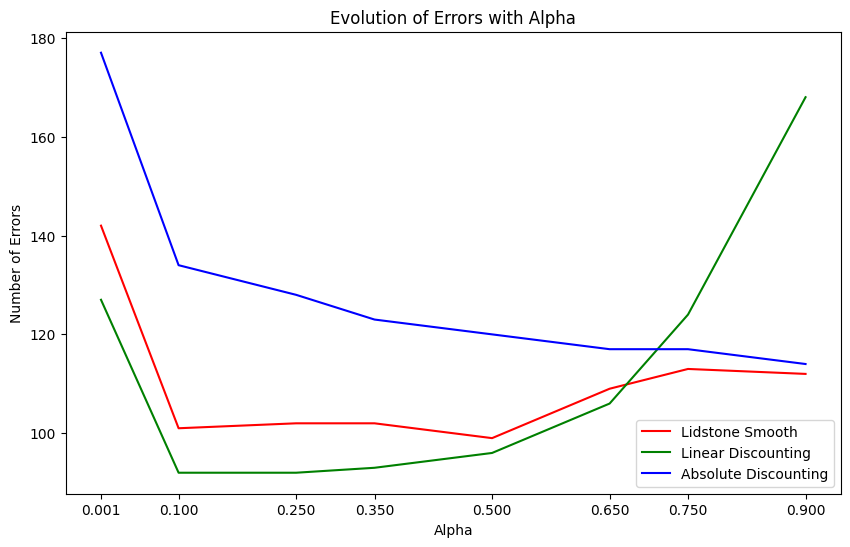

VALIDATION RESULTS:
Smoothing: linear_discounting, Alpha: 0.1, , Errors: 92
Smoothing: linear_discounting, Alpha: 0.25, , Errors: 92
Smoothing: linear_discounting, Alpha: 0.35, , Errors: 93
Smoothing: linear_discounting, Alpha: 0.5, , Errors: 96
Smoothing: lidstone_smooth, Alpha: 0.5, , Errors: 99
Smoothing: lidstone_smooth, Alpha: 0.1, , Errors: 101
Smoothing: lidstone_smooth, Alpha: 0.25, , Errors: 102
Smoothing: lidstone_smooth, Alpha: 0.35, , Errors: 102
Smoothing: linear_discounting, Alpha: 0.65, , Errors: 106
Smoothing: lidstone_smooth, Alpha: 0.65, , Errors: 109
Smoothing: lidstone_smooth, Alpha: 0.9, , Errors: 112
Smoothing: lidstone_smooth, Alpha: 0.75, , Errors: 113
Smoothing: absolute_discounting, Alpha: 0.9, , Errors: 114
Smoothing: absolute_discounting, Alpha: 0.65, , Errors: 117
Smoothing: absolute_discounting, Alpha: 0.75, , Errors: 117
Smoothing: absolute_discounting, Alpha: 0.5, , Errors: 120
Smoothing: absolute_discounting, Alpha: 0.35, , Errors: 123
Smoothing: linear

In [ ]:
# Plot to show the evolution of errors with alpha
plt.figure(figsize=(10, 6))

plt.plot(x_values_lidstone, y_values_lidstone, 'r-', label='Lidstone Smooth')
plt.plot(x_values_linear, y_values_linear, 'g-', label='Linear Discounting')
plt.plot(x_values_absolute, y_values_absolute, 'b-', label='Absolute Discounting')

plt.title('Evolution of Errors with Alpha')
plt.xlabel('Alpha')
plt.xticks(alphas)
plt.ylabel('Number of Errors')
plt.legend()

plt.show()

# Print the results of the validation sorted by the number of errors
print("VALIDATION RESULTS:")
validation_results_sorted = sorted(validation_results_dict.values(), key = lambda x: len(x["errors"]))
for res in validation_results_sorted:
    print(f"Smoothing: {res['smoothing']}, Alpha: {res['alpha']}, , Errors: {len(res['errors'])}")

## Test

Total errors: 72 out of 59977 sentences.
Total accuracy: 0.998799539823599
*Accuracy deu: 0.9991991991991992
*Accuracy eng: 0.99969960949234
*Accuracy fra: 0.9988
*Accuracy ita: 0.9984
*Accuracy nld: 0.9978
*Accuracy spa: 0.9989


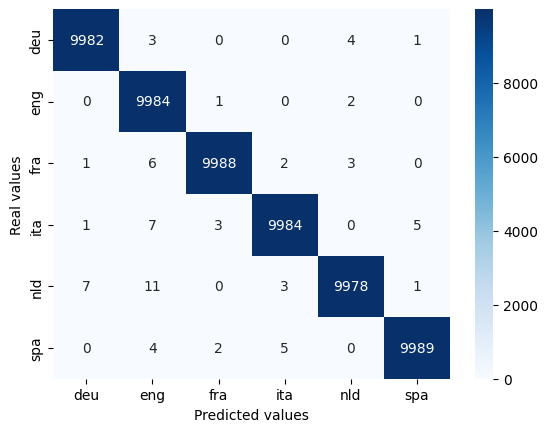

WRONG PREDICTIONS:
*True: deu, Predicted: spa, Text: "  autos wie den dacia sandero.  "
*True: deu, Predicted: nld, Text: "  b. angioödem, stevensjohnsonsyndrom, toxische epidermale nekrolyse gegen lenalidomid gezeigt haben.  "
*True: deu, Predicted: eng, Text: "  darunter das restaurant mappamondo und der takeawaybetrieb the beef burger.  "
*True: deu, Predicted: nld, Text: "  der stoffbeutel war leer.  "
*True: deu, Predicted: nld, Text: "  hij was de leider van de groep in de provincie khorasan van de islamitische staat.  "
*True: deu, Predicted: eng, Text: "  jarjarthomas . jan theorethisch ist es simpel.  "
*True: deu, Predicted: eng, Text: "  was ist wicop?  "
*True: deu, Predicted: nld, Text: "  wat er nu gebeurt, is heel zwaar voor hem als jonge gast.  "
*True: eng, Predicted: nld, Text: "  in asia, japan's nikkei .  "
*True: eng, Predicted: fra, Text: "  internet trouble.  "
*True: eng, Predicted: nld, Text: "  vancouver head coach willie desjardins.  "
*True: fra, Predicted: 

In [45]:
# Test
prediction_errors_list = []
predictions = {language: [] for language in test.keys()}

prob_dict = create_prob_dict(model=trigrams, b_value_dict=b_values, smooth=linear_discounting, param=0.25)

language_list = test.keys()
sentences = []
for k in test.keys():
    sentences += test[k]


for language in language_list:
	for sentence in test[language]:
		probs = []
		sentence = "  "+sentence+"  " # Add spaces to the beginning and end of the sentence for better results
		trigram_finder = TrigramCollocationFinder.from_words(sentence)
		for lingua in language_list:
			prob_sec = 0
			for trigram, num_instances in trigram_finder.ngram_fd.items():
				prob_sec += num_instances * prob_dict[lingua].get(trigram, prob_dict[lingua]["None"])
			probs.append((lingua, prob_sec))
		max_prob = max(probs, key = lambda x: x[1])
		predictions[language].append(max_prob[0])
		if max_prob[0] != language:
			prediction_errors_list.append({"text": sentence, "true": language, "pred": max_prob[0]})

# Calculate accuracy
correct_predictions = {language: sum([1 for pred in predictions[language] if pred == language]) for language in test.keys()}
total_accuracy = sum(correct_predictions.values()) / sum([len(value) for value in test.values()])

# Print results
print(f"Total errors: {len(prediction_errors_list)} out of {sum([len(value) for value in test.values()])} sentences.")
print(f"Total accuracy: {total_accuracy}")
for language, correct in correct_predictions.items():
	print(f"*Accuracy {language}: {correct / len(test[language])}")

# Confusion matrix
language_names = [language for language in test.keys()]

cm = confusion_matrix(y_true=[language for language in test.keys() for _ in range(len(test[language]))],
					  y_pred=[pred for language in test.keys() for pred in predictions[language]],
					  labels=language_names)

sns.heatmap(data=cm, annot=True, fmt="d", xticklabels=language_names, yticklabels=language_names, cmap="Blues")
plt.xlabel('Predicted values')
plt.ylabel('Real values')
plt.show()

# Print the errors
print("WRONG PREDICTIONS:")
for error in prediction_errors_list:
	print(f"*True: {error['true']}, Predicted: {error['pred']}, Text: \"{error['text']}\"")